In [1]:
suppressPackageStartupMessages({
    
    library(limma)
    library(rrcovNA)
    library(imputeLCMD)


    library(ggplot2)
    library(patchwork)
    library(ggsci)
    library(ggExtra)
    
})


options(warn = -1)


impute.perseus <- function(x, width=0.3, shift=1.8) {
  # distributions are induced by measured values in each sample
  data.mean <- colMeans(x, na.rm = TRUE)
  data.sd <- matrixStats::colSds(x, na.rm = TRUE)
  n <- nrow(x)
  z <- rmvnorm(n, mean = data.mean - shift*data.sd , sigma = diag(data.sd*width))
  x[is.na(x)] <- z[is.na(x)]
  return(x)
}

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}


devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")

masterMix_proteins <- c("P02754","P80025","P00921","P00366","P02662","P61823",
                        "P02789","P12799","P02676","P02672", "P02666","P68082") 

ℹ Loading msImpute



### Read data and filter

In [2]:
data <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PASS00589/Standard-Profiling-Sample-Set/combined/txt/evidence.txt", stringsAsFactors = FALSE)


# data <- data[grep("CON_|REV_", data$Leading.razor.protein, invert=TRUE),]
data <- data[data$Charge > 1,]
data$PeptideID <- paste0(data$Modified.sequence, data$Charge)
data$matrix.row.id <- paste(data$PeptideID, data$Leading.Razor.Protein, sep ="_")


genes <- data[,c("PeptideID","matrix.row.id", "Leading.Razor.Protein")]
genes <- genes[!duplicated(genes),]


y <- evidenceToMatrix(data)
genes <- genes[match(rownames(y), genes$PeptideID),]


y_dda <- log2(y)

rownames(y) <- genes$matrix.row.id[match(rownames(y), genes$PeptideID)]
rownames(y_dda) <- genes$matrix.row.id[match(rownames(y_dda), genes$PeptideID)]


keep3 <- (!grepl("CON__|REV__", genes$Leading.Razor.Protein))
keep4 <- (!grepl("[a-z]+", genes$PeptideID))

y_dda <- y_dda[keep3&keep4,]
y <- y[keep3&keep4,]



group <- gsub(".*_SGSDS(sample[1-8])_(R0[1-3])_MSG",
              "\\1",
              colnames(y_dda))

design <- model.matrix(~ group)

### Imputation (barycenter + SOTA methods)

In [3]:
library(MSstats)
#### msStats####
proteinGroups<-read.table("/stornext/General/data/academic/lab_davis/prot/benchmarking/PASS00589/Standard-Profiling-Sample-Set/combined/txt/proteinGroups.txt",
                          sep="\t", header=TRUE)

# Read in MaxQuant file: evidence.txt
infile <- read.table("/stornext/General/data/academic/lab_davis/prot/benchmarking/PASS00589/Standard-Profiling-Sample-Set/combined/txt/evidence.txt", 
                     sep="\t", header=TRUE)

# Read in annotation including condition and biological replicates
annot <- data.frame('Raw.file' = infile$Raw.file)
annot <- annot[!duplicated(annot$Raw.file),, drop = FALSE]
annot$Condition <- gsub('B_D140314_SGSDS(sample[0-9])_R0[0-9]_MSG','\\1',annot$Raw.file)
annot$BioReplicate <- gsub('B_D140314_SGSDS(sample[0-9])_R0([0-9])_MSG','\\2',annot$Raw.file)
annot$Experiment <- gsub('B_D140314_SGSDS(sample[0-9])_R0([0-9])_MSG','\\1_\\2',annot$Raw.file)
annot$IsotopeLabelType <- 'L'

quant <- MaxQtoMSstatsFormat(evidence=infile, annotation=annot, proteinGroups=proteinGroups,
                             useUniquePeptide = TRUE,
                             summaryforMultipleRows = max,
                             removeProtein_with1Peptide=TRUE)


processed.quant <- dataProcess(quant,
                               normalization = 'equalizeMedians',
                               summaryMethod="TMP",
                               cutoffCensored="minFeature",
                               censoredInt="NA",
                               MBimpute=TRUE,
                               maxQuantileforCensored=0.999)

y_msstats <- processed.quant$ProcessedData
y_msstats$peptide_id <- paste0(y_msstats$PEPTIDE,'_', y_msstats$PROTEIN)
y_msstats <- y_msstats[,c('peptide_id', 'originalRUN', 'ABUNDANCE')]
y_msstats <- tidyr::spread(y_msstats, 'originalRUN', 'ABUNDANCE')
rownames(y_msstats) <- y_msstats$peptide_id
y_msstats$peptide_id <- NULL



rownames(y_msstats) <- paste0('_',rownames(y_msstats))



y_dda <- y_dda[rowSums(!is.na(y_dda)) >= 4,]



y_msstats <- y_msstats[match(rownames(y_dda), rownames(y_msstats)),]



** + Contaminant, + Reverse, + Only.identified.by.site, proteins are removed.

** Peptide and charge, that have 1 or 2 measurements across runs, are removed.

** 563 proteins, which have only peptide and charge in a protein, are removed among 3075 proteins.

** Log2 intensities under cutoff = 14.936  were considered as censored missing values.

** Log2 intensities = NA were considered as censored missing values.

** Use all features that the dataset origianally has.



                       
  Summary of Features :
                         count
# of Protein              2511
# of Peptides/Protein    2-138
# of Transitions/Peptide   1-1
                      
  Summary of Samples :
                           sample1 sample2 sample3 sample4 sample5 sample6
# of MS runs                     3       3       3       3       3       3
# of Biological Replicates       3       3       3       3       3       3
# of Technical Replicates        1       1       1       1       1       1
                           sample7 sample8
# of MS runs                     3       3
# of Biological Replicates       3       3
# of Technical Replicates        1       1



 Summary of Missingness :


  # transitions are completely missing in at least one of the conditions : 11977


    -> FDLNEPLHLSFLQNAAK_3_NA_NA, LATSISETLEEK_2_NA_NA, VCPTTETIYNDEFYTK_2_NA_NA, VVQTDETAR_2_NA_NA, ACDLPAWVHFPDTER_3_NA_NA ...


  # run with 75% missing observations: 0



 == Start the summarization per subplot...



  |======================================================================| 100%



 == the summarization per subplot is done.



In [4]:
y_msImpute <- msImpute(y_dda, 
                       a = 0.3,
                       method = "v2-mnar", 
                       group = group)

Running msImpute version 2

Estimate distribution under MAR assumption

rank is 16

computing lambda0 ...

lambda0 is 156.582715167033

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar



In [5]:
y_MLE <- impute.wrapper.MLE(y_dda)
y_impSeq <- impSeq(y_dda)
y_knn <- impute.wrapper.KNN(y_dda, K = 15)


y_minDet <- impute.MinDet(y_dda, q = 0.01)


y_perseus <- impute.perseus(y_dda)

# pcv <- plotCV2(limma::normalizeBetweenArrays(y_perseus,
#                                              method = 'quantile'), 
#                main = "perseus")

y_qrilc <- impute.QRILC(y_dda, 1)[[1]]


sOa_imps <- readRDS("/stornext/Home/data/allstaff/h/hediyehzadeh.s/softImpute_low_rank_experimentation/impute_PASS00589_DDA_sOa_filter4obs_noNorm.rds")



names(sOa_imps) <- c("RF","Mice","EM","BPCA","LLS")

sOa_imps <- sOa_imps[c("RF","Mice","EM","BPCA")]

z <- m <- rownames(sOa_imps[[1]])
# m <- paste0("_", m)

rowsname <- rownames(y)[rownames(y) %in% m]



mats <- list(
             "KNN"= y_knn[rowsname,],
           
             "impSeq" = y_impSeq[rowsname,],
             
             "barycenter" = y_msImpute, 
             
             "baseline" = y[rowsname,],
             "MSstats_AFT" = y_msstats[rowsname,])





mats <- c(sOa_imps, mats)

Cluster size 25286 broken into 11954 13332 
Cluster size 11954 broken into 5092 6862 
Cluster size 5092 broken into 2567 2525 
Cluster size 2567 broken into 1247 1320 
Done cluster 1247 
Done cluster 1320 
Done cluster 2567 
Cluster size 2525 broken into 883 1642 
Done cluster 883 
Cluster size 1642 broken into 923 719 
Done cluster 923 
Done cluster 719 
Done cluster 1642 
Done cluster 2525 
Done cluster 5092 
Cluster size 6862 broken into 2483 4379 
Cluster size 2483 broken into 1124 1359 
Done cluster 1124 
Done cluster 1359 
Done cluster 2483 
Cluster size 4379 broken into 2289 2090 
Cluster size 2289 broken into 1022 1267 
Done cluster 1022 
Done cluster 1267 
Done cluster 2289 
Cluster size 2090 broken into 1003 1087 
Done cluster 1003 
Done cluster 1087 
Done cluster 2090 
Done cluster 4379 
Done cluster 6862 
Done cluster 11954 
Cluster size 13332 broken into 7580 5752 
Cluster size 7580 broken into 191 7389 
Done cluster 191 
Cluster size 7389 broken into 6939 450 
Cluster siz

### Differential abundance testing

In [6]:
n_ups <- 500
fdr_thresh <- 0.05

topN <- list()
fullTables <- list()
fullTables2 <- list()
for(i in seq_along(mats)){
  message("processing ", names(mats)[i])
   if(names(mats)[i] != "MSstats_AFT"){
     E <- normalizeBetweenArrays(mats[[i]], method = "quantile")
   }else{
     E <- mats[[i]]
   }

   fit <- lmFit(E, design = design)

   fit <- eBayes(fit)
   print(summary(decideTests(fit)))

  tp <- topTable(fit, coef=ncol(fit), number = Inf, p.value = 1)
  tp$de <- ifelse(tp$adj.P.Val < fdr_thresh, 1,0)
  tp$isUPS <- ifelse(gsub("(.*)_(.*)_(.*)","\\3", rownames(tp)) %in% masterMix_proteins,1,0)
  tp$TP <- ifelse(tp$de==1 & tp$isUPS==1,1,0) # a ups called DE is a true positive
  tp$FN <- ifelse(tp$de==0 & tp$isUPS==1,1,0) # a ups called not DE is a false negative
  tp$FN_unestim <- ifelse(is.na(tp$adj.P.Val) & tp$isUPS==1,1,0)
  tp$fd <- ifelse(tp$isUPS==0 & tp$de ==1 ,1,0) # & !complete.cases(y_dda[match(rownames(tp), rownames(y_dda)),])
  tp$FDR <- cumsum(tp$fd)/cumsum(tp$de)
  topN[[names(mats)[i]]] <- data.frame(N=seq_len(n_ups),
                                       numUPS=cumsum(tp$isUPS)[seq_len(n_ups)],
                                       FDR=tp$FDR[seq_len(n_ups)],
                                       nominalFDR= ifelse(seq_len(n_ups) == which(tp$adj.P.Val > fdr_thresh)[1],1,0),
                                       method=names(mats)[i])
  
  


  fullTables[[names(mats)[i]]] <- data.frame(

    predictions = -log10(tp$P.Value),
    labels = tp$isUPS
    
    
    
    )
  
  fullTables2[[names(mats)[i]]] <- data.frame(

    
    TP = cumsum(tp$TP),
    FP = cumsum(tp$fd),
    TP_total = sum(tp$TP, na.rm = TRUE),
    FP_total = sum(tp$fd, na.rm = TRUE),
    FN_total = sum(tp$FN, na.rm = TRUE),
    FN_unestim_total = sum(tp$FN_unestim, na.rm = TRUE)
    
    

    
    )
}


topN <- do.call(rbind, topN)
fullTables <- do.call(rbind, fullTables)
fullTables$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables))
fullTables$predictions[is.na(fullTables$predictions)] <- 0


fullTables2 <- do.call(rbind, fullTables2)
fullTables2$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables2))

processing RF



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0           66          101          103
NotSig           0        25286        25219        25184        25089
Up           25286            0            1            1           94
       groupsample6 groupsample7 groupsample8
Down            103          105          893
NotSig        25066        25054        23516
Up              117          127          877


processing Mice



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0           31           94          255
NotSig           0        25286        25255        25183        24786
Up           25286            0            0            9          245
       groupsample6 groupsample7 groupsample8
Down            263          255         1071
NotSig        24765        24787        23173
Up              258          244         1042


processing EM



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0           58           83          116
NotSig           0        25286        25227        25201        25077
Up           25286            0            1            2           93
       groupsample6 groupsample7 groupsample8
Down            105          131         1087
NotSig        25068        25002        23134
Up              113          153         1065


processing BPCA



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0           49           72           87
NotSig           0        25286        25236        25213        25133
Up           25286            0            1            1           66
       groupsample6 groupsample7 groupsample8
Down             71           78         1141
NotSig        25143        25111        22852
Up               72           97         1293


processing KNN



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            3           16           46           78
NotSig           0        25279        25269        25237        25159
Up           25286            4            1            3           49
       groupsample6 groupsample7 groupsample8
Down             55           59          285
NotSig        25171        25159        24748
Up               60           68          253


processing impSeq



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0           54          101          400
NotSig           0        25286        25232        25182        24448
Up           25286            0            0            3          438
       groupsample6 groupsample7 groupsample8
Down            468          540         1899
NotSig        24283        24099        21491
Up              535          647         1896


processing barycenter



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            1            5           75          119
NotSig           0        25283        25278        25203        25078
Up           25286            2            3            8           89
       groupsample6 groupsample7 groupsample8
Down            121          140          281
NotSig        25064        25020        24708
Up              101          126          297


processing baseline



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0           15           62           83           43
NotSig        2908        21559        21676        22080        22036
Up           22378            1            3            2           40
       groupsample6 groupsample7 groupsample8
Down             39           29          185
NotSig        21756        21474        18262
Up               52           50          188


processing MSstats_AFT



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0           47           61           26
NotSig           0        17268        17362        17711        17686
Up           20267            0            4            2           15
       groupsample6 groupsample7 groupsample8
Down             18            7          168
NotSig        17481        17207        14671
Up               18           15          103


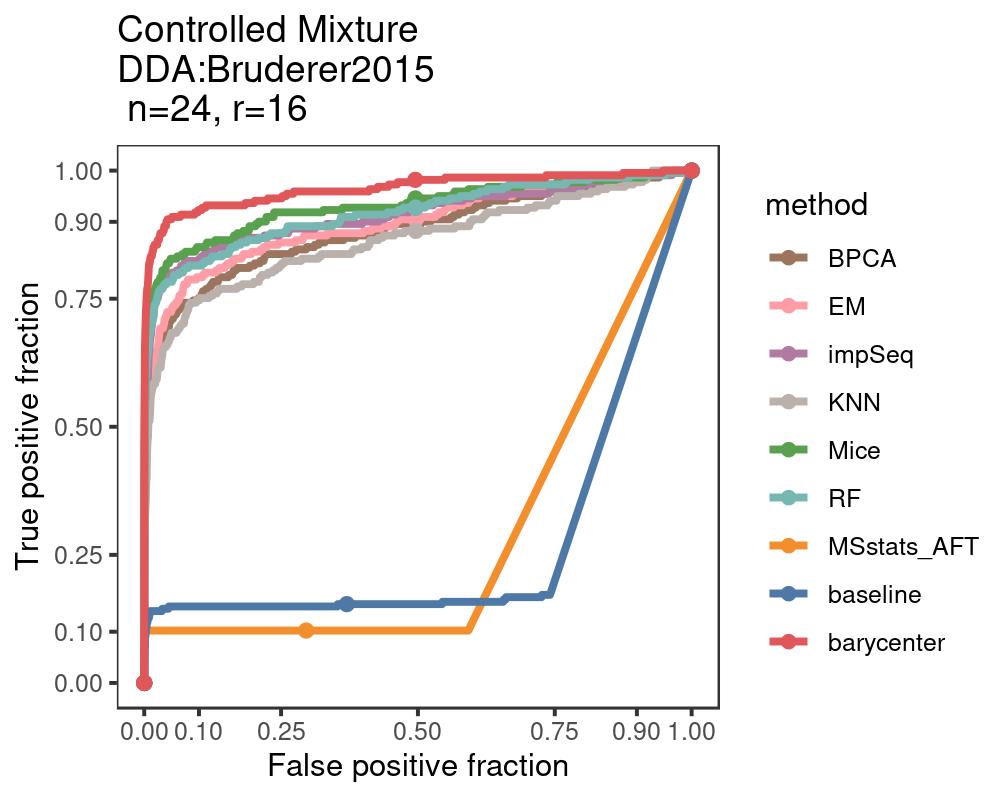

In [13]:
fig.size(4, 5)

library(plotROC)
library(ggthemes)


col_pal <- tableau_color_pal(palette = "Tableau 10", direction = -1)(9)
col_pal[col_pal == "#EDC948"] = "#BAB0AC"
names(col_pal) <- c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","barycenter","MSstats_AFT","baseline")


fullTables$method <- factor(fullTables$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","MSstats_AFT","baseline","barycenter"))

p2 <- ggplot(fullTables, aes(m = predictions, d = labels, group = method, color = method))+ geom_roc(n.cuts=3,labels=FALSE) +
   style_roc(guide=FALSE) + 
  scale_color_manual(values = col_pal) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        #legend.position = 'None'
       ) 




fullTables2$method <- factor(fullTables2$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","MSstats_AFT", "baseline","barycenter"))


dataset_name = 'PASS00589'

print(p2 + labs(title = "Controlled Mixture \nDDA:Bruderer2015\n n=24, r=16"))


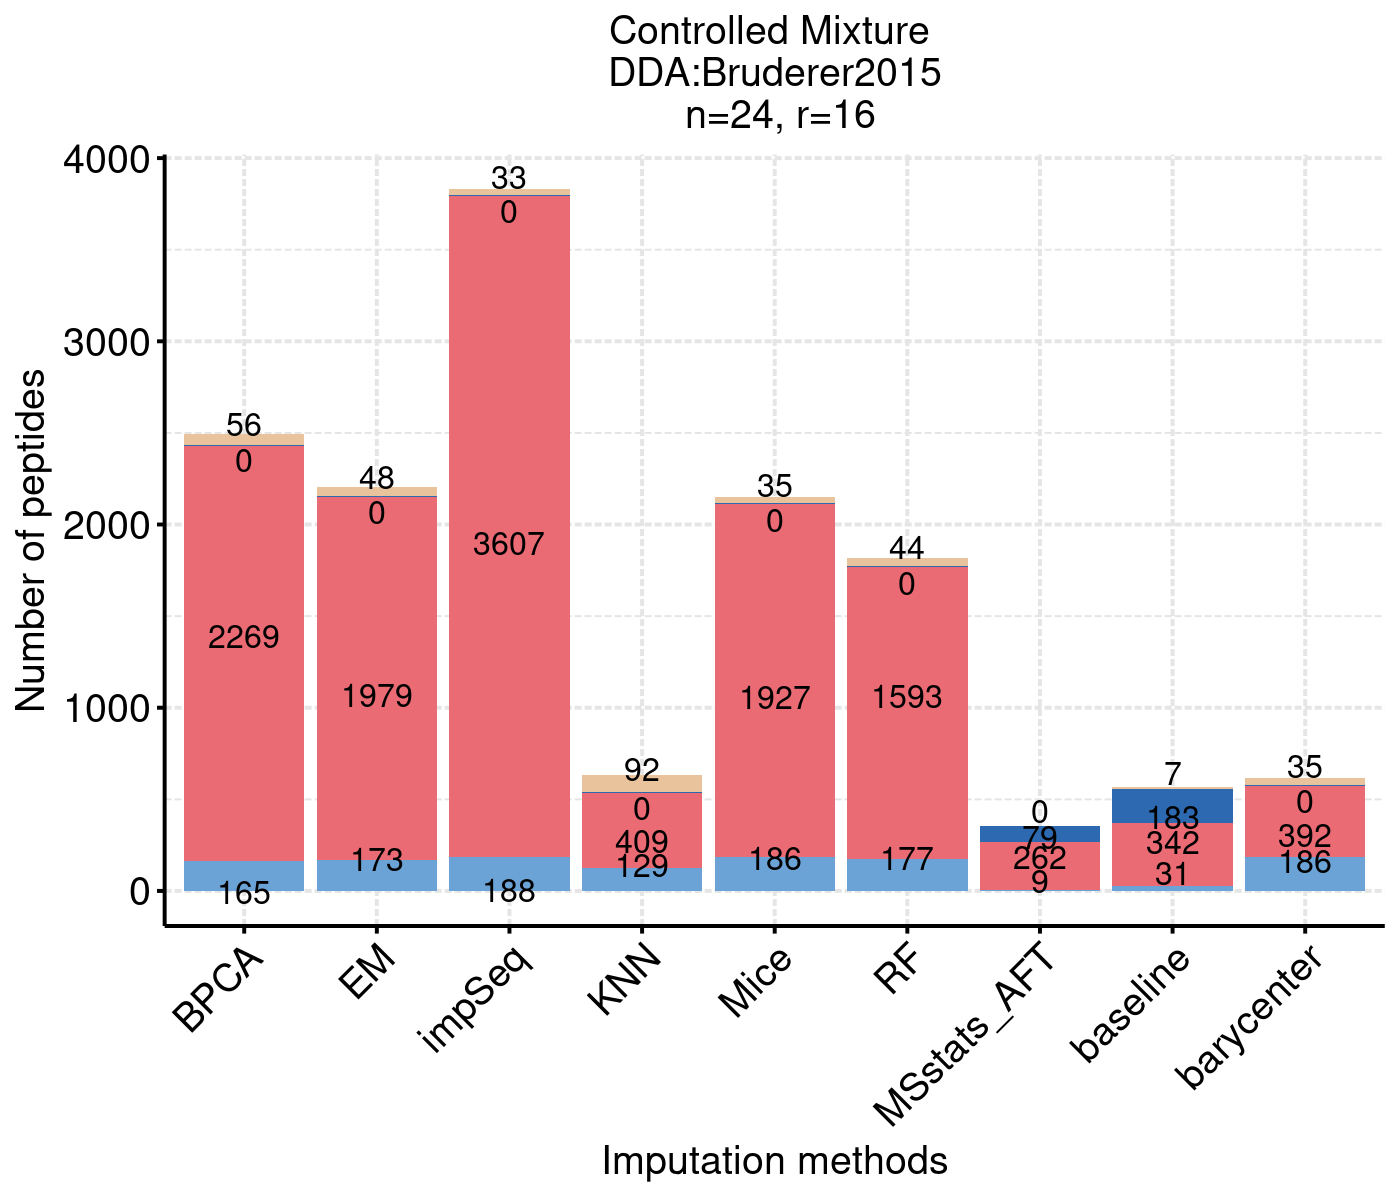

In [14]:
fig.size(6,7)

# Barplot of True positive, false positives and false negatives for all methods at FDR 0.05
ggdat <- fullTables2[,grep("method|total", colnames(fullTables2))]
ggdat <- ggdat[!duplicated(ggdat$method),]
colnames(ggdat) <- gsub("_total", "", colnames(ggdat))


ggdat <- reshape2::melt(ggdat, id = "method")
ggdat$method <- factor(ggdat$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","MSstats_AFT","baseline","barycenter"))


ggdat$variable <- gsub("TP", "True Positive", ggdat$variable)
ggdat$variable <- gsub('FN_unestim', 'False Negative(unestimable)', ggdat$variable)
ggdat$variable <- gsub("FP", "False Positive", ggdat$variable)
ggdat$variable <- gsub("FN", "False Negative", ggdat$variable)



# png(file = "~/barplot_PASS00589.png",
#     width=6,height=5,units="in",res=1200)

p <- ggplot(ggdat, aes(x=method, y = value, fill = variable, label=value)) +
  geom_bar(stat = "identity", position="stack") +

  ggrepel::geom_text_repel(size = 4, 
            position = position_stack(vjust = 0.5), direction = "y", 
            box.padding = unit(0.01, "lines")) + 
  xlab('Imputation methods') + ylab('Number of peptides') + 
  labs(fill="type", title = "Controlled Mixture \nDDA:Bruderer2015\n n=24, r=16") +  
  
  scale_fill_manual(values = c('False Negative(unestimable)' = "#2c69b0",
                               'False Negative' = "#e9c39b" ,
                               'True Positive' = "#6ba3d6", 
                               'False Positive' = "#ea6b73")) + 
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12),
                legend.position = "none"
     ) 

# print(p)
# dev.off()
p


FALSE  TRUE 
14727 10559 

png 
  2

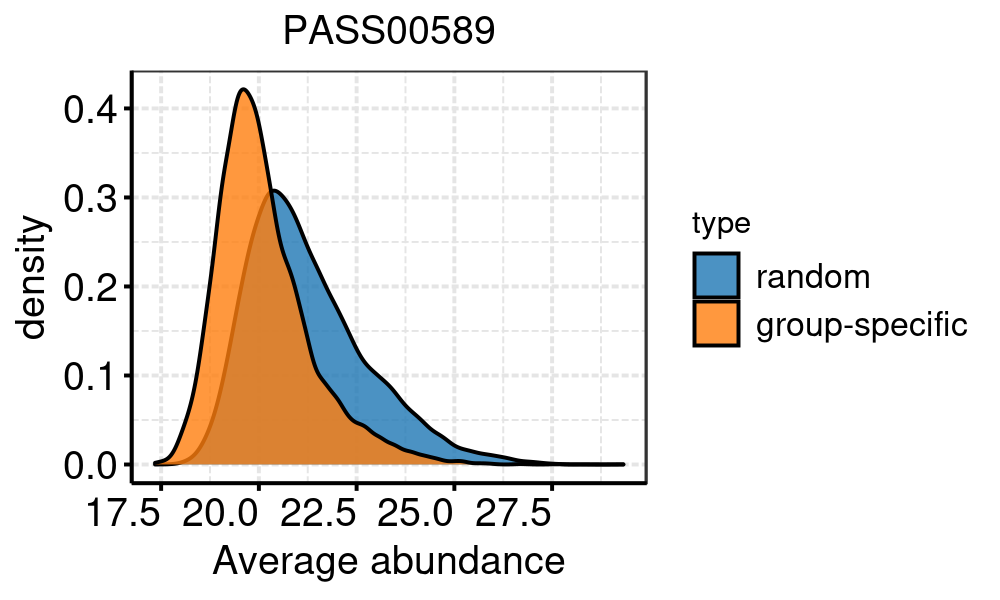

In [9]:
fig.size(3,5)


# Visualization of the ebm metric for assessment of missing types
hdp <- selectFeatures(y_dda[rowSums(!is.na(y_dda)) >= 4,],
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1
# hist(ebms)
# plot(hdp$AveExpr, ebms, pch = 16, cex = 0.3)




ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))


png(file = "~/hist_missingtype_PASS00589.png",
    width=5,height=3,units="in",res=1200)

p <- ggplot(ggdat, aes(x=AveExpr, fill = type)) +
  geom_density(alpha = 0.8) + scale_fill_d3() +
  theme_bw() + labs(title = "PASS00589", x="Average abundance")  +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

print(p)
dev.off()
p

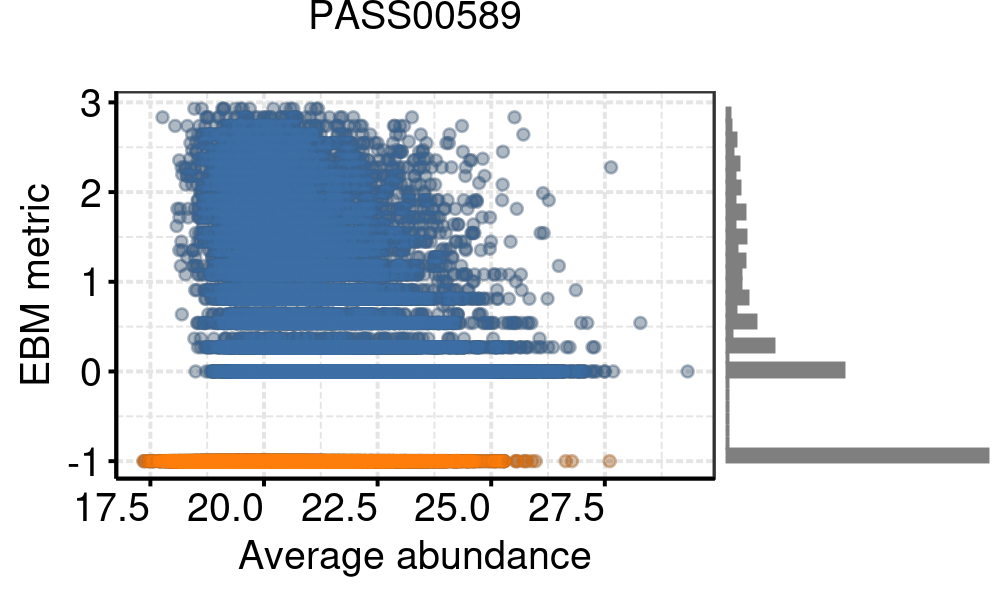

In [10]:
fig.size(3,5)


# EBM vs Ave abundance
p <- ggplot(ggdat, aes(x=AveExpr, y = metric)) +
  geom_point(alpha = 0.2) + 
  geom_point(data = subset(ggdat, metric == -1),alpha = 0.2, 
             color = "#FF7F0EFF") + 
  geom_point(data = subset(ggdat, metric != -1),alpha = 0.2, color = "#3E71A8") +
  #stat_bin_2d() +
  #geom_rug(sides = "b", alpha = 0.05) +
  theme_bw() +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) + labs(x='Average abundance', y = 'EBM metric', title = "PASS00589")

p1 <- ggMarginal(p, type="histogram", margins = "y", 
                 fill = "gray50", color = "gray50", 
                 size = 2.1)


# png(file = "~/scatter_ebm_abundance_PASS00589.png",
#     width=5,height=3,units="in",res=1200)

# print(p1)
# dev.off()
p1


FALSE  TRUE 
14727 10559 

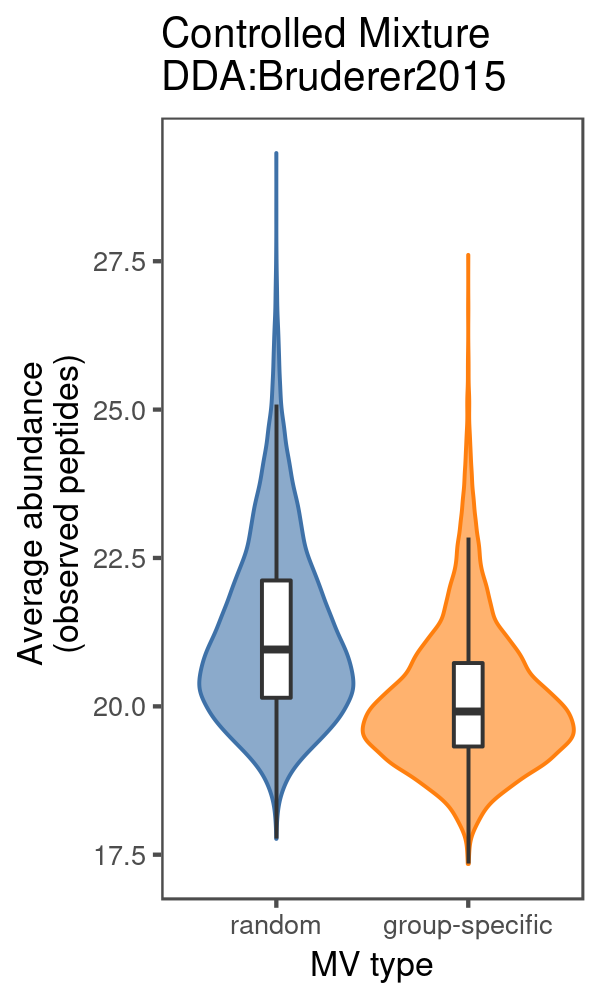

In [15]:
fig.size(5,3)
hdp <- selectFeatures(y_dda,
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1




library(ggExtra)
library(ggthemes)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))


# plot in the original manuscript ------
# EBM vs Ave abundance
pebm <- ggplot(ggdat, aes(x=AveExpr, y = metric)) +
  geom_point(alpha = 0.2) + 
  geom_point(data = subset(ggdat, metric == -1),alpha = 0.2, color = "#FF7F0EFF") + 
  geom_point(data = subset(ggdat, metric != -1),alpha = 0.2, color = "#3E71A8") +

  theme_bw() +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) + labs(x='Average abundance', y = 'EBM metric', title= dataset_name)

pebm <- ggMarginal(pebm, type="histogram", margins = "y", 
                 fill = "gray50", color = "gray50", 
                 size = 2.1)


# png(file = "~/scatter_ebm_abundance_PXD016647.png",
#     width=5,height=3,units="in",res=1200)

# print(p1)
# dev.off()
# pebm

# replace with grouped violin plots -----
# png(file = paste0("revision_figures/violin_",dataset_name,".png"),
#     width=3.5,height=5.55, units="in",res=300)
pv <- ggplot(ggdat, aes(x=type, y = AveExpr)) + 
  geom_violin(aes(fill = type, color = type), alpha = 0.6, width = 1.1, show.legend = FALSE) +
  # stat_summary(fun.data=mean_sdl,
  #                geom="pointrange", color="black") +
  geom_boxplot(width=0.15, outlier.shape = NA) + 
  scale_fill_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  scale_color_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  labs(fill = '', y = 'Average abundance \n (observed peptides)', x = 'MV type',
       title = "Controlled Mixture \nDDA:Bruderer2015") +
  theme_few() 

print(pv)
# dev.off()

### Session information

In [12]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggthemes_4.2.4      plotROC_2.2.1       MSstats_3.22.1     
 [4] msImpute_1.7.1      ggExtra_0.9         ggsci_2.9          
 [7] patchwork_1.1.1     ggplot2_3.3.3       imputeLCMD_2.0     
[10] impute_1.64.0    